# Neural Network Regression for House Price Prediction

This notebook trains a simple feed-forward neural network (MLP) to predict house prices on the **House Prices – Advanced Regression Techniques** Kaggle dataset. The idea is to see whether a nonlinear model can capture patterns that linear models miss.

Assumption: `train.csv` is in the same folder as this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Load and Inspect the Data

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(df['SalePrice'].describe())
df.isna().sum().sort_values(ascending=False).head(20)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

## Basic Cleaning and Feature Definition

In [4]:
df = df.drop(columns=['Id'])

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print('Numeric features:', len(numeric_features))
print('Categorical features:', len(categorical_features))

Numeric features: 36
Categorical features: 43


## Train/Validation Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_val.shape

((1168, 79), (292, 79))

## Preprocessing and Neural Network Model

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

nn_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', mlp)
    ]
)
nn_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'L...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 32),
                              max_iter=300, random_state=42))])

## Train the Neural Network

In [7]:
nn_model.fit(X_train, y_train)
print('Neural network training finished.')

Neural network training finished.


/Users/evodie/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


## Evaluation: MSE and MAE

In [8]:
y_pred = nn_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f'Neural Network Regression MSE: {mse:.2f}')
print(f'Neural Network Regression MAE: {mae:.2f}')

Neural Network Regression MSE: 1509930924.66
Neural Network Regression MAE: 22116.44


## Plots: Actual vs Predicted and Residuals

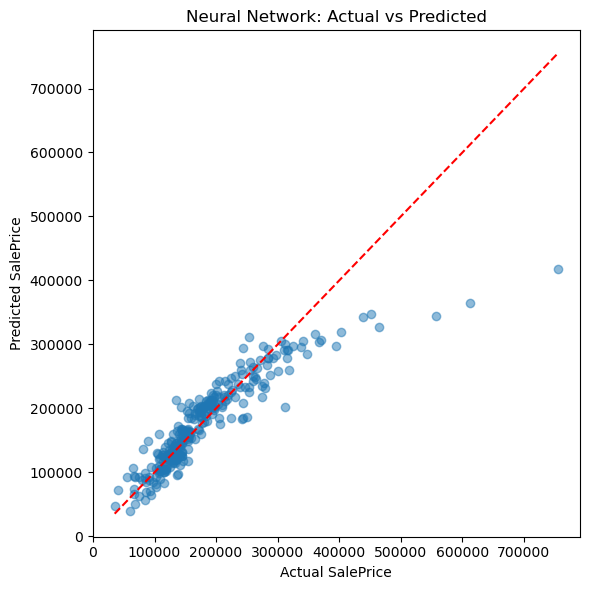

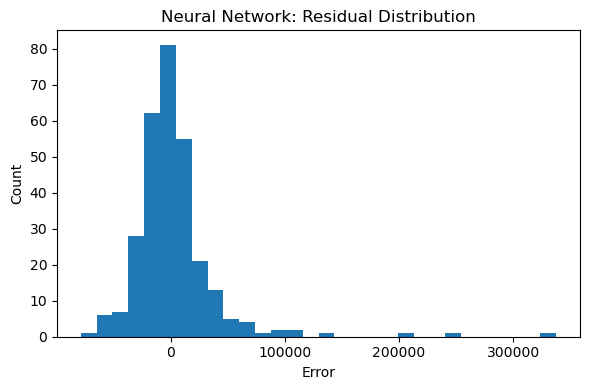

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Neural Network: Actual vs Predicted')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.tight_layout()
plt.show()

residuals = y_val - y_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30)
plt.title('Neural Network: Residual Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()